In [10]:
#Load Importance sampling functions
import sys
sys.path.append('../src')

In [11]:
import datetime, zarr, dask, rasterio as rio, rioxarray as rxr, pandas as pd, rasterstats, tqdm, pathlib, geopandas as gpd, matplotlib.pyplot as plt
from scipy.stats import uniform, norm, multivariate_normal, truncnorm
import plotnine as pn
import os
import subprocess
import importlib
import pyDOE2
from tqdm import tqdm
import numpy as np

from transpose import *
from utils import *
from evaluation import *

<h5>Download Data</h5>

In [ ]:
# Run only once
#Download data from AWS
#1. In terminal - 
    # curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    # unzip awscliv2.zip
    # sudo ./aws/install
#3. In terminal inside docker type - aws configure
#4. Add key provided by admin and set region to us-west-2 and output format to json

#Duwamish S3 URL for tif files 
s3_url = "s3://importance-sampling-sst/Duwamish/"
local_dir = "/workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish"
os.makedirs(local_dir)
subprocess.run(["aws","s3","cp",s3_url,local_dir,"--recursive"], check = True)

<h5> Load Data </h5>

In [12]:
#Locate data
path_sp_watershed = "/workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/geojson/duwamish.geojson"
path_sp_domain = "/workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/geojson/duwamish-transpo-area-v01.geojson"

path_storm = pathlib.Path('/workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/catalog')
df_storms = pd.read_pickle(path_storm/'catalog.pkl')

In [13]:
#Load shapefiles and match projection with rasters
sp_watershed = gpd.read_file(path_sp_watershed)
sp_watershed = match_crs_to_raster(sp_watershed, df_storms['path'].iloc[0])

sp_domain = gpd.read_file(path_sp_domain)
sp_domain = match_crs_to_raster(sp_domain, df_storms['path'].iloc[0])

Reprojecting polygon from EPSG:4326 to EPSG:5070...
Reprojecting polygon from EPSG:4326 to EPSG:5070...


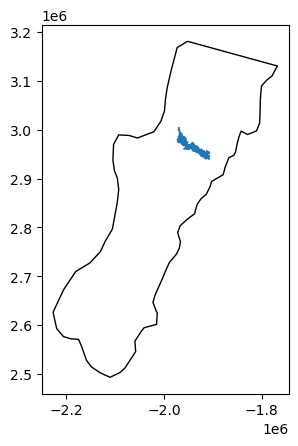

In [14]:
sp_watershed.plot()
sp_domain.plot(ax=plt.gca(),facecolor="none")
plt.show()

In [15]:
v_watershed_stats = get_sp_stats(sp_watershed)
v_domain_stats = get_sp_stats(sp_domain)
print(v_watershed_stats, v_domain_stats)

minx       -1.974568e+06
miny        2.938089e+06
maxx       -1.905108e+06
maxy        3.005395e+06
x          -1.942311e+06
y           2.965859e+06
range_x     6.946011e+04
range_y     6.730658e+04
area_km2    1.257913e+03
Name: 0, dtype: float64 minx       -2.226803e+06
miny        2.493512e+06
maxx       -1.768135e+06
maxy        3.180672e+06
x          -2.008039e+06
y           2.857018e+06
range_x     4.586682e+05
range_y     6.871599e+05
area_km2    1.188145e+05
Name: 0, dtype: float64


<h5> Sampling </h5>

In [7]:
rho_storms = compute_rho_from_storms(df_storms)
print(f"Empirical rho from storm centers: {rho_storms:.3f}")

Empirical rho from storm centers: 0.984


In [16]:
n_sim_mc_0 = 1000000
n_sim_is_1 = 10000
df_storm_sample_mc_0 = sample_storms(df_storms, v_domain_stats,v_watershed_stats,method = "Uniform", num_simulations=n_sim_mc_0)
df_storm_sample_mc_1 = sample_storms(df_storms, v_domain_stats,v_watershed_stats, method = "Uniform", num_simulations=n_sim_is_1)
df_storm_sample_is_1 = sample_storms(df_storms, v_domain_stats,v_watershed_stats, method = "BVN",rho = 0,sigma_scale=5, num_simulations=n_sim_is_1)

In [13]:
#Full Monte
df_depths_mc_0 = compute_depths(df_storm_sample_mc_0, sp_watershed)

100%|██████████| 10000/10000 [02:28<00:00, 67.44it/s]


In [ ]:
#Store
#os.makedirs("/workspaces/Importance-Sampling-for-SST/data/1_interim/Duwamish", exist_ok=True)
#df_depths_mc_0.to_pickle("/workspaces/Importance-Sampling-for-SST/data/1_interim/Duwamish/df_depths_mc_0.pkl")

In [17]:
df_depths_mc_0 = pd.read_pickle("/workspaces/Importance-Sampling-for-SST/data/1_interim/Duwamish/df_depths_mc_0.pkl")

In [9]:
#Small Sample
df_depths_mc_1 = compute_depths(df_storm_sample_mc_1, sp_watershed)
df_depths_is_1 = compute_depths(df_storm_sample_is_1, sp_watershed)

100%|██████████| 10000/10000 [02:28<00:00, 67.30it/s]


In [18]:
df_freq_curve_mc_0 = get_return_period_poisson(df_depths_mc_0.depth, df_depths_mc_0.prob, lambda_rate = 10)
df_freq_curve_mc_1 = get_return_period_poisson(df_depths_mc_1.depth, df_depths_mc_1.prob, lambda_rate = 10)
df_freq_curve_is_1 = get_return_period_poisson(df_depths_is_1.depth, df_depths_is_1.prob, lambda_rate= 10)

<h5> Evaluate </h5>

In [19]:
print(f"Max depth for Full Monte Carlo is {df_freq_curve_mc_0['depth'].max():.2f} mm")
print(f"Max depth for Partial Monte Carlo is {df_freq_curve_mc_1['depth'].max():.2f} mm")
print(f"Max depth for Importance Sampling is {df_freq_curve_is_1['depth'].max():.2f} mm")

Max depth for Full Monte Carlo is 351.18 mm
Max depth for Partial Monte Carlo is 317.33 mm
Max depth for Importance Sampling is 338.16 mm


In [20]:
print_sim_stats(df_depths_mc_0)
print_sim_stats(df_depths_mc_1)
print_sim_stats(df_depths_is_1)

Intersected: 87347 out of 100000 (87.35%)
Total Weights: Total  1.00, Intersected: 0.87
Depth: 21.20 ± 0.11
Depth Estimate: 21.20 ± 0.11
Intersected: 8787 out of 10000 (87.87%)
Total Weights: Total  1.00, Intersected: 0.88
Depth: 21.17 ± 0.35
Depth Estimate: 21.17 ± 0.35
Intersected: 9565 out of 10000 (95.65%)
Total Weights: Total  1.00, Intersected: 0.90
Depth: 38.79 ± 0.43
Depth Estimate: 4.93 ± 0.33


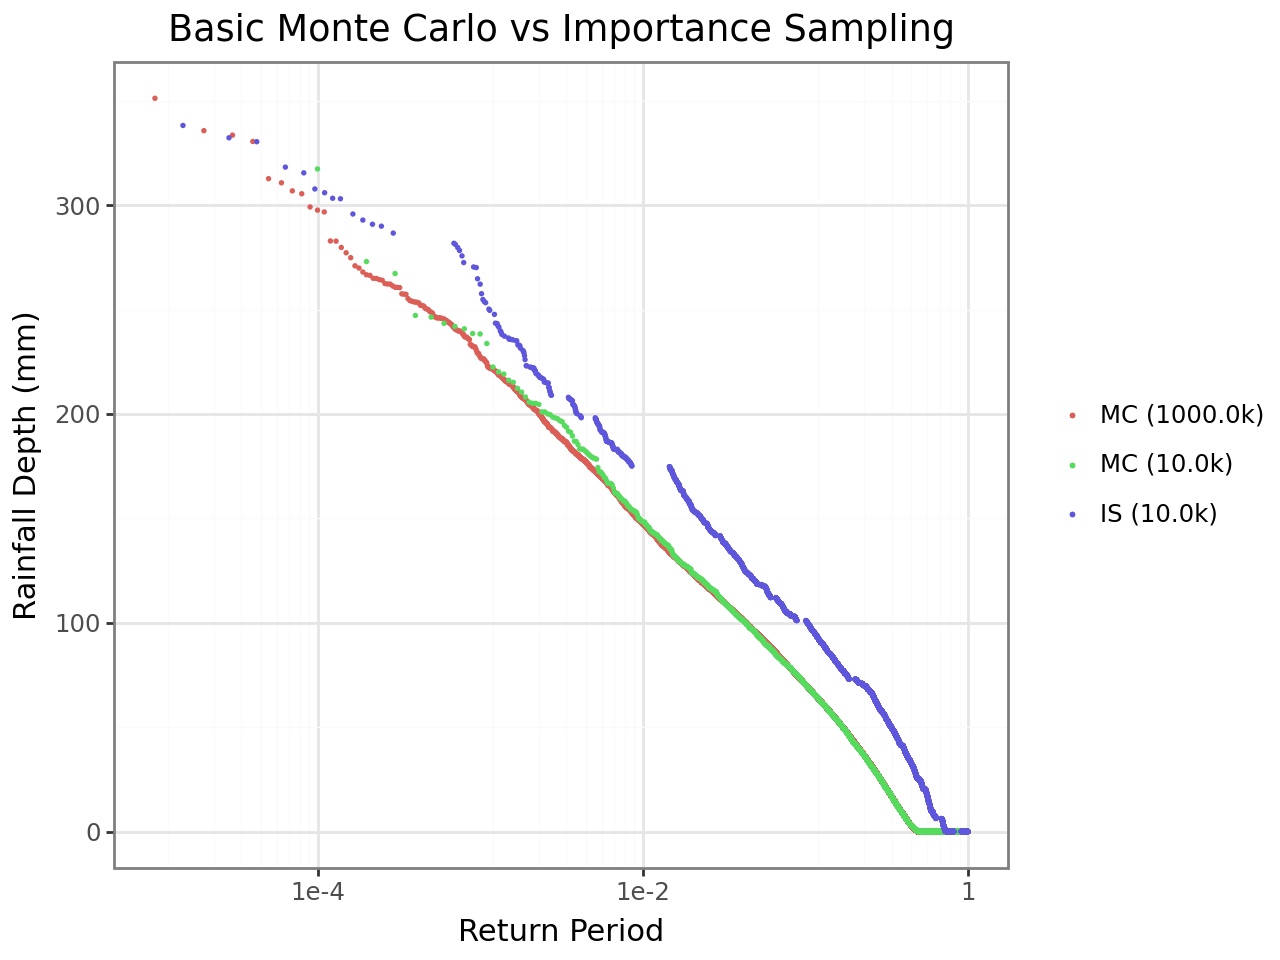

In [21]:
(pn.ggplot(mapping=pn.aes(x='prob_exceed', y='depth'))
        + pn.geom_point(data=df_freq_curve_mc_0, mapping=pn.aes(color=f'"MC ({n_sim_mc_0/1000}k)"'), size=0.1)
        + pn.geom_point(data=df_freq_curve_mc_1, mapping=pn.aes(color=f'"MC ({n_sim_is_1/1000}k)"'), size=0.1)
        + pn.geom_point(data=df_freq_curve_is_1, mapping=pn.aes(color=f'"IS ({n_sim_is_1/1000}k)"'), size=0.1)
        + pn.scale_x_log10()
        + pn.labs(
            x = 'Return Period',
            y = 'Rainfall Depth (mm)',
            title = 'Basic Monte Carlo vs Importance Sampling'
        )
        + pn.theme_bw()
        + pn.theme(
            title = pn.element_text(hjust = 0.5),
            # legend_position = 'bottom',
            legend_title = pn.element_blank(),
            legend_key = pn.element_blank(),
            axis_title_y = pn.element_text(ha = 'left'),
        )
    )

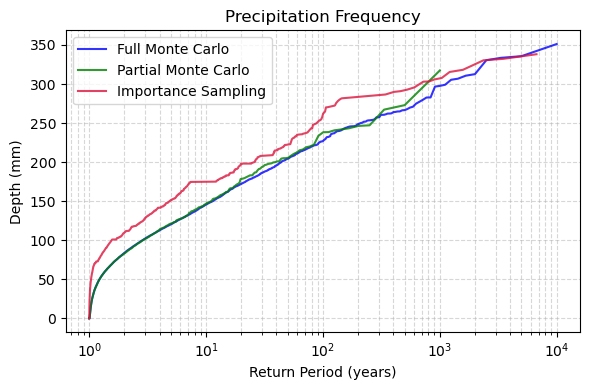

In [22]:
# Plot Return Period vs Depth with better colors
plt.figure(figsize=(6, 4))

plt.semilogx(df_freq_curve_mc_0['return_period'], df_freq_curve_mc_0['depth'],
             linestyle='-', color='blue', alpha=0.8, label='Full Monte Carlo')

plt.semilogx(df_freq_curve_mc_1['return_period'], df_freq_curve_mc_1['depth'],
             linestyle='-', color='green', alpha=0.8, label='Partial Monte Carlo')

plt.semilogx(df_freq_curve_is_1['return_period'], df_freq_curve_is_1['depth'],
             linestyle='-', color='crimson', alpha=0.8, label='Importance Sampling')

plt.xlabel('Return Period (years)')
plt.ylabel('Depth (mm)')
plt.title('Precipitation Frequency')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

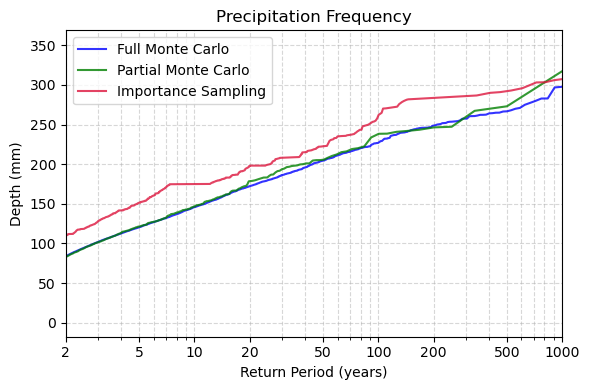

In [23]:
plt.figure(figsize=(6, 4))

plt.semilogx(df_freq_curve_mc_0['return_period'], df_freq_curve_mc_0['depth'],
             linestyle='-', color='blue', alpha=0.8, label='Full Monte Carlo')

plt.semilogx(df_freq_curve_mc_1['return_period'], df_freq_curve_mc_1['depth'],
             linestyle='-', color='green', alpha=0.8, label='Partial Monte Carlo')

plt.semilogx(df_freq_curve_is_1['return_period'], df_freq_curve_is_1['depth'],
             linestyle='-', color='crimson', alpha=0.8, label='Importance Sampling')

plt.xlabel('Return Period (years)')
plt.ylabel('Depth (mm)')
plt.title('Precipitation Frequency')

# Custom x-axis ticks on log scale
ticks = [2, 5, 10, 20, 50, 100, 200, 500,1000]
plt.xlim(2, 1000)
plt.xticks(ticks, labels=[str(t) for t in ticks])

plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
n_sim_mc_0 = 1000000
n_sim_is_1 = 10000
df_storm_sample_mc_0 = sample_storms(df_storms, v_domain_stats,v_watershed_stats,method = "Uniform", num_simulations=n_sim_mc_0)
df_storm_sample_mc_1 = sample_storms(df_storms, v_domain_stats,v_watershed_stats, method = "Uniform", num_simulations=n_sim_is_1)
df_storm_sample_is_1 = sample_storms(df_storms, v_domain_stats,v_watershed_stats, method = "BVN",rho = 0,sigma_scale=2, num_simulations=n_sim_is_1)

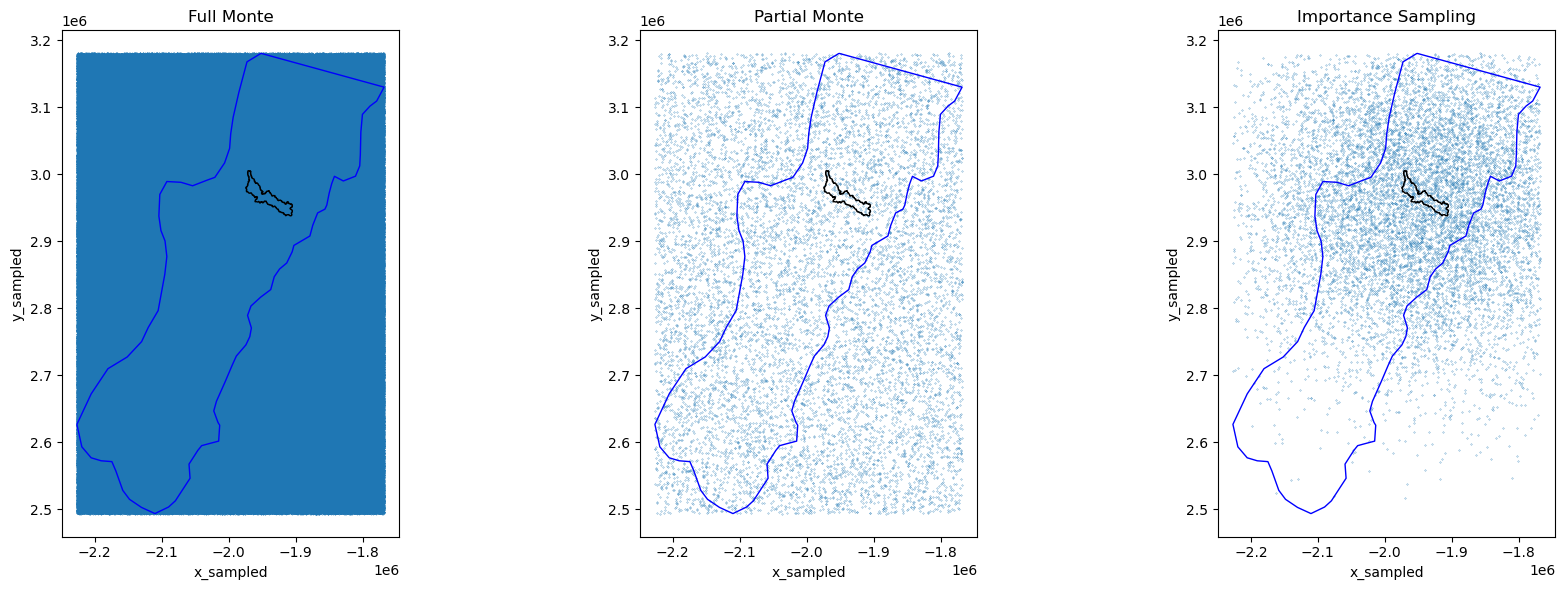

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
titles = ["Full Monte", "Partial Monte", "Importance Sampling"]
dfs = [df_storm_sample_mc_0, df_storm_sample_mc_1, df_storm_sample_is_1]

for ax, df, title in zip(axes, dfs, titles):
    df.plot.scatter(x="x_sampled", y="y_sampled", s=0.05, alpha=1, ax=ax)
    sp_watershed.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1)
    sp_domain.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1)
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [2]:
pip install treelib

Note: you may need to restart the kernel to use updated packages.


In [4]:
from treelib import Node, Tree

tree = Tree()
tree.create_node("my_project", "root")

# Package folder
tree.create_node("mymodule", "pkg", parent="root")
tree.create_node("__init__.py", "init", parent="pkg")

# math_utils.py
tree.create_node("math_utils.py", "math", parent="pkg")
tree.create_node("add(a, b)", "add", parent="math")
tree.create_node("multiply(a, b)", "mult", parent="math")

# string_utils.py
tree.create_node("string_utils.py", "string", parent="pkg")
tree.create_node("to_uppercase(s)", "toupper", parent="string")
tree.create_node("reverse_string(s)", "reverse", parent="string")

# file_utils.py
tree.create_node("file_utils.py", "file", parent="pkg")
tree.create_node("read_file(path)", "read", parent="file")
tree.create_node("write_file(path, content)", "write", parent="file")

# Standalone script
tree.create_node("catalog_functions.py", "catalog", parent="root")

tree.show()

my_project
├── catalog_functions.py
└── mymodule
    ├── __init__.py
    ├── file_utils.py
    │   ├── read_file(path)
    │   └── write_file(path, content)
    ├── math_utils.py
    │   ├── add(a, b)
    │   └── multiply(a, b)
    └── string_utils.py
        ├── reverse_string(s)
        └── to_uppercase(s)



In [17]:
df_storm_sample_is_1

,name,path,x,y,x_sampled,y_sampled,prob,weight,x_del,y_del
0,20211222_T408,/workspaces/Importance-Sampling-for-SST/data/0...,-2.004087e+06,2.867055e+06,-1.913863e+06,2.723543e+06,0.000097,3.029663,90223.959860,-143512.389518
1,20031015_T014,/workspaces/Importance-Sampling-for-SST/data/0...,-1.935599e+06,3.014813e+06,-1.797723e+06,2.980858e+06,0.000081,2.543457,137875.739856,-33954.390898
2,20101227_T388,/workspaces/Importance-Sampling-for-SST/data/0...,-2.043477e+06,2.775126e+06,-2.008299e+06,2.671506e+06,0.000111,3.477940,35177.829279,-103620.887926
3,20031015_T014,/workspaces/Importance-Sampling-for-SST/data/0...,-1.935599e+06,3.014813e+06,-2.140724e+06,2.818942e+06,0.000096,3.017276,-205125.682990,-195870.615630
4,19970926_T369,/workspaces/Importance-Sampling-for-SST/data/0...,-1.962467e+06,2.955794e+06,-2.211977e+06,2.920121e+06,0.000101,3.178955,-249510.237535,-35672.675147
...,...,...,...,...,...,...,...,...,...,...
9995,19951107_T026,/workspaces/Importance-Sampling-for-SST/data/0...,-1.970149e+06,2.922246e+06,-1.989838e+06,2.589959e+06,0.000140,4.388791,-19688.559322,-332286.323006
9996,20071117_T212,/workspaces/Importance-Sampling-for-SST/data/0...,-2.033121e+06,2.776594e+06,-2.127232e+06,2.897952e+06,0.000087,2.740063,-94111.500775,121358.123058
9997,20110228_T213,/workspaces/Importance-Sampling-for-SST/data/0...,-2.007092e+06,2.851208e+06,-1.937313e+06,2.612629e+06,0.000129,4.042325,69779.191267,-238578.425659
9998,19951228_T327,/workspaces/Importance-Sampling-for-SST/data/0...,-2.021506e+06,2.815594e+06,-2.101520e+06,2.814741e+06,0.000091,2.862695,-80013.443702,-853.549264
